In [1]:
from make_animation import make_3d_animation
from argon_calculation import *
import time as tm

# Data processing 
figure_directory = './exported_figs/'
data_directory = './exported_data/'
data_name_identifyer = 'N256_Full_data_acqui'     # Specify what data is contained
data_header = ['N', 'T', 'Rho', 'C_v', 'C_v_sig', 'P', 'P_sig', 'Run_time']
write_data(data_directory, data_name_identifyer, data_header)
significance = 5
    
# Configuration of the simulation

## Parameters
TRho = [[2.89,0.85],[2.2,0.85],[1.21,0.85],[1.13,0.85],[0.88,0.85],[2.84,0.75],[0.827,0.75],[4.62,0.45],[2.93,0.45],
        [1.71,0.45],[1.51,0.45],[0.99,0.88],[1.01,0.8],[1.014,0.7]] #[0.5,1.2],[1,0.8],[3,0.3],[1.06,0.827],[0.827,1.06]] # sequence of [T, Rho] 

delta_t = 4e-3                     # Time step size in simulation
time_steps = 5001                  # Time steps in simulation
t_max = time_steps*delta_t         # Maximum simulation time

## Defining the geometry 
unit_power = 4                     # amount of cells alone 1 axis (drawn from 'xyz'), N = N_unit * unit_power^3
N_unit = 4                         # 4 partciles per unit cell for fcc
dim = 3                            # dimensions of the problem, fcc should use 3D
lattice = "fcc"                    # fcc or random
algorithm = "verlet"               # euler or velvet

## Renormalization parameters
conf_level = 1                     # amount of standard deviations from the average temperature
inter_numb = 1                     # number of interactions per particle
renorm_count_max = 20              # times that renorm function was called but no renorm was necesary (already correct T)
equi_data = 5001                   # datapoints wanted in equilibrium position

## Paircorrelationn
bin_resolution = 100               # Number of bins per 1 unit cell

## Bootstrap parameters
trials = 1000
pair_cor_trials = 1

for T, density in TRho:
    start_time = tm.time()
            
    unit_cells, unit_size, L, N = init_cells(unit_power, N_unit, density) # Initialize geometry
    bin_number = int(bin_resolution*L)
    bin_delta = (L-0)/bin_number

    # Main calculation
    E_kin, E_pot, T_tot, pos, Sum_rF, differ_bins, last_data_iteration,\
    last_renorm_time, bins, bin_edges, t_range = argon_simu(
        t_max, delta_t, L, N, dim, lattice, algorithm, conf_level, 
        inter_numb, renorm_count_max, equi_data, bin_resolution,
        bin_number, bin_delta, unit_cells, unit_power, unit_size, T)
    
    end_time = tm.time()
    total_time = end_time - start_time
    print('N =',N,',','# Time steps = ',last_data_iteration)
    print('Simulation time:', np.round(total_time,2), 's')
    
    # Data processing
    ## Bootstrap sequence
    btstrp_seq = btstrp_rnd_gen(trials, last_data_iteration, last_renorm_time)

    ## C_v, P & Pair correlation 
    P_ave, P_sig = pressure(trials, btstrp_seq, last_data_iteration, last_renorm_time, Sum_rF, N, T)
    C_v_ave, C_v_sig = specific_heat(trials, btstrp_seq, last_data_iteration, last_renorm_time, E_kin, N)
    pair_cor_x, pair_cor_y = pair_correlation(pair_cor_trials, last_data_iteration, last_renorm_time, differ_bins, bin_number, L, N, bin_delta, bins, bin_edges)
    
    ## Write data to csv
    data_row = [N, T, density, np.round(C_v_ave,significance), np.round(C_v_sig,significance), np.round(P_ave,significance), np.round(P_sig,significance), round(total_time)]
    append_data(data_directory, data_name_identifyer, data_row)
    
    ## Plotting + writing to specified directory
    figure_filename = write_figure(figure_directory, N, T, density)
    plot_pair_cor(pair_cor_x, pair_cor_y, L, figure_filename)
    plot_energy(t_range, N, E_pot, E_kin, last_data_iteration, delta_t, figure_filename)
    plot_temperature(t_range, T_tot, T, last_data_iteration, delta_t, figure_filename)
    
    print('')
    print('P_ave =', np.round(P_ave,3),',','P_sig =', np.round(P_sig,3))
    print('C_v_ave =', np.round(C_v_ave,3),',','C_v_sig =', np.round(C_v_sig,3))
    print('______________________________________________')

N = 32 , # Time steps =  5000
Simulation time: 4.15 s

P_ave = 2.352 , P_sig = 0.075
C_v_ave = 3.399 , C_v_sig = 0.096
______________________________________________
N = 32 , # Time steps =  5000
Simulation time: 3.36 s

P_ave = 1.052 , P_sig = 0.025
C_v_ave = 2.463 , C_v_sig = 0.032
______________________________________________
N = 32 , # Time steps =  5000
Simulation time: 3.44 s

P_ave = 0.995 , P_sig = 0.013
C_v_ave = 1.65 , C_v_sig = 0.004
______________________________________________
N = 32 , # Time steps =  5000
Simulation time: 3.84 s

P_ave = 1.052 , P_sig = 0.027
C_v_ave = 2.641 , C_v_sig = 0.048
______________________________________________
N = 32 , # Time steps =  5000
Simulation time: 3.75 s

P_ave = 2.611 , P_sig = 0.039
C_v_ave = 2.653 , C_v_sig = 0.041
______________________________________________


In [ ]:
# Make an animation

from IPython.display import HTML

anim = make_3d_animation(L, pos, delay=10, initial_view=(30, 20), rotate_on_play=0)
HTML(anim.to_html5_video())

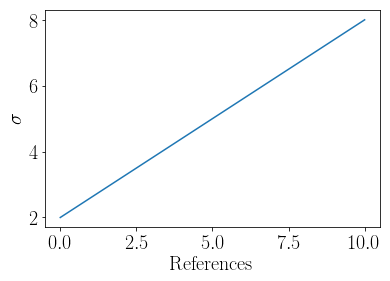

In [34]:
import numpy as np
import copy as cp
import matplotlib.pyplot as plt


plt.rc('text', usetex=True)
plt.rc('font', size = 20)
QQ = np.linspace(2,8,100)
XX = np.linspace(0,10,100)
plt.plot(XX,QQ)
plt.xlabel('$\mathrm{References}$')
plt.ylabel('$\sigma$')
plt.show()

In [13]:
'''
import numpy as np
import copy as cp
import matplotlib.pyplot as plt


plt.rc('text', usetex=True)
plt.rc('font')#, size = 'default')
QQ = np.linspace(2,8,100)
XX = np.linspace(0,10,100)
plt.plot(XX,QQ)
QQ2 = np.linspace(5,8,100)
XX2 = np.linspace(0,10,100)
plt.plot(XX2,QQ2)
QQ3 = np.linspace(8,2,100)
XX3 = np.linspace(0,10,100)
plt.plot(XX3,QQ3
plt.legend(['$\mathrm{Potential energy}$','$\mathrm{Kinetic energy}$','$\mathrm{Total energy}$']

plt.xlabel('$\mathrm{References}$')
plt.ylabel('$\sigma$')
plt.show()
'''

"\nimport numpy as np\nimport copy as cp\nimport matplotlib.pyplot as plt\n\n\nplt.rc('text', usetex=True)\nplt.rc('font')#, size = 'default')\nQQ = np.linspace(2,8,100)\nXX = np.linspace(0,10,100)\nplt.plot(XX,QQ)\nQQ2 = np.linspace(5,8,100)\nXX2 = np.linspace(0,10,100)\nplt.plot(XX2,QQ2)\nQQ3 = np.linspace(8,2,100)\nXX3 = np.linspace(0,10,100)\nplt.plot(XX3,QQ3\nplt.legend(['$\\mathrm{Potential energy}$','$\\mathrm{Kinetic energy}$','$\\mathrm{Total energy}$']\n\nplt.xlabel('$\\mathrm{References}$')\nplt.ylabel('$\\sigma$')\nplt.show()\n"